In [269]:
import numpy as np
from numpy.linalg import inv
from scipy.optimize import linprog
import timeit

import matplotlib.pyplot as plt
import seaborn as sns

In [270]:
sns.set(rc={'figure.figsize':(14,8.27)}, font_scale=2)
sns.set_palette('colorblind')

# A)

$l_1$: $||$**x**$||_1 = |x_1| + ... + |x_m|$
$l_2$: $||$**x**$||_2 = \sqrt{|x_1|^2 + ... + |x_m|^2}$
$l_\infty$: $||$**x**$||_\infty = max(|x_1| , ... , |x_m|)$

$min_x$$||Ax-b||_1 = \sum_{i=1}^m |  a_{i} x - b_i |$
$min_x$$||Ax-b||_2 = \sqrt{ \sum_{i=1}^m ( a_{i} x - b_i ) ^2 }$
$min_x$$||Ax-b||_ \infty = min_x (max_i|a_i^Tx - b_i|)$

$||Ax-b||_2^2 =  \sum_i^m \left( \sum_j^n a_{ij} x_j - b_i \right) ^2$
produces minimum when gradient is zero w.r.t. $x$.

$\frac{\partial f}{\partial x_p} = 2 \sum_i^m  a_{ip} \sum_j^n ( a_{ij} x_j - b_i ) = 0$  <br/>
$ 2 \sum_i^m  a_{ip} \sum_j^n a_{ij} x_j  = 2 \sum_i^m a_{ip} \sum_j^n  b_i $

in matrix form:
<br/>
$  A^T A x =  A^T b$
$  \rightarrow  x =  (A^T A)^{-1} A^T b$ <br/>

Convex as quadratics only have one minimum

# B)

$min_x$$||Ax-b||_ \infty = min_x (max_i|a_i^Tx - b_i|)$
$min_x$$||Ax-b||_ \infty = min_x (min_t( -t \leq a_i^Tx - b_i \leq t))$
$min_x (min_t( -t \leq a_i^Tx - b_i \leq t)) = min_{x,t} t$
with $-t \leq a_i^Tx - b_i \leq t$ for $i=1,...,m$
This is equivalent to $min_x \tilde{c}^T \tilde{x}$ with constraint $\tilde{A} \tilde{x} \leq \tilde{b}$
Where $$ \tilde{x} =
\left(\begin{array}{cc}
x \\
t
\end{array}\right)
$$
$$ \tilde{c} =
\left(\begin{array}{cc}
0 \\
1
\end{array}\right)
$$
$$ \tilde{A} =
\left(\begin{array}{cc}
A & -1\\
-A & -1
\end{array}\right)
$$
$$ \tilde{b} =
\left(\begin{array}{cc}
b\\
-b
\end{array}\right)
$$

$min_x$$||Ax-b||_1 = \sum_{i=1}^m |  a_{i} x - b_i |$
$min_x$$||Ax-b||_1 = min_x \sum_{i=1}^m min_{t_i}( -t \leq a_i^Tx - b_i \leq t)$
which is $min_{x,t_i} \sum_{i=1}^m t_1$
with $-t_i \leq a_i^Tx - b_i \leq t_i$ for $i=1,...,m$
This is equivalent to $min_x \tilde{c}^T \tilde{x}$ with constraint $\tilde{A} \tilde{x} \leq \tilde{b}$
Where $$ \tilde{x} =
\left(\begin{array}{cc}
x \\
t
\end{array}\right)
$$
$$ \tilde{c} =
\left(\begin{array}{cc}
0 \\
\textbf{1}
\end{array}\right)
$$
$$ \tilde{A} =
\left(\begin{array}{cc}
A & -\textbf{I}\\
-A & -\textbf{I}
\end{array}\right)
$$
$$ \tilde{b} =
\left(\begin{array}{cc}
b\\
-b
\end{array}\right)
$$

# C)

$min_x \tilde{c}^T \tilde{x}$ subject to $\tilde{A} \tilde{x} \leq \tilde{b}$

Lagragian:
$L(x, \lambda) = \tilde{c}^T \tilde{x} +  \lambda^T (\tilde{A} \tilde{x} - \tilde{b})$
$= - \tilde{b}^T \lambda + (\tilde{A}^T \lambda + \tilde{c})^T \tilde{x}$

Dual Cost:
$min_x L(x, \lambda) = - \tilde{b}^T \lambda$ if $\tilde{A}^T \lambda + \tilde{c} = 0$
or $- \infty$ otherwise

Dual LP problem:
$max_{\lambda}( - \tilde{b}^T \lambda)$ subject to $\tilde{A}^T \lambda + \tilde{c} = 0$ and $\lambda \geq 0$

# D)/E)

In [271]:
Ab = []
for i in range(5):
    A = np.genfromtxt('2023-data/A' + str(i) + '.csv', delimiter=",")
    b = np.genfromtxt('2023-data/b' + str(i) + '.csv', delimiter=",")
    Ab.append((A, b))

In [272]:
def lp(data, norm, method, iterations):
    times = np.zeros(5)
    residuals = [None] * 5
    opt = np.zeros(5)
    low_bound = np.zeros(5)
    for iter in range(iterations):
        for i, (A,b) in enumerate(data):

            m, n = A.shape

            if norm != 'l1' and norm != 'linf':
                print('Error: incorrect norm')
                return
            elif norm == 'l1':
                c_til = np.zeros((n + m, 1))
                c_til[-m:] = 1
                b_til = np.hstack((b, -b))
                I = np.eye(m)
                A_til = np.vstack((np.hstack((A, -I)), np.hstack((-A, -I))))
            else:
                c_til = np.zeros((n + 1, 1))
                c_til[-1:] = 1
                b_til = np.hstack((b, -b))
                I = np.eye(m)
                A_til = np.vstack((np.hstack((A, -np.ones((m, 1)))), np.hstack((-A, -np.ones((m, 1))))))

            start_time = timeit.default_timer()

            result = linprog(c_til, A_ub=A_til, b_ub=b_til, method=method)

            time = timeit.default_timer() - start_time

            dual_result = linprog(-b_til, A_eq=A_til.T, b_eq=-c_til, bounds=(0, None) ,method=method)

            low_bound[i] = dual_result['fun']

            residuals[i] = A @ result['x'][:n] - b
            opt[i] = result['fun']
            times[i] += time / iterations

    return opt, times, residuals, low_bound

## $l_1$ norm

### i) Simplex Method

In [273]:
l1_smp_opt, l1_smp_times, l1_smp_residuals, l1_smp_low = lp(Ab, 'l1', 'highs', 1)

In [274]:
print(l1_smp_opt)
print(l1_smp_low)
print(l1_smp_times)

[ 13.96450782  56.34628742 176.28757375 367.82788344 807.641611  ]
[  -8.64075088  -40.47091323 -132.38945303 -265.56673929 -577.27186875]
[2.40330000e-03 2.51556000e-02 1.91360270e+00 2.11643985e+01
 2.15909205e+02]


(array([0.00493377, 0.00493377, 0.00986755, 0.00493377, 0.04933775,
        0.02960265, 0.0197351 , 0.07894039, 0.08880794, 0.12334437,
        0.13814569, 0.19735099, 0.26642383, 0.28615893, 0.36016555,
        0.350298  , 0.37496688, 0.45390727, 0.4292384 , 0.47364237,
        2.83692045, 0.42430462, 0.36016555, 0.41443707, 0.41443707,
        0.34536423, 0.34043045, 0.25162251, 0.29109271, 0.17761589,
        0.17761589, 0.10854304, 0.0592053 , 0.0592053 , 0.0394702 ,
        0.03453642, 0.00493377, 0.00493377, 0.00493377, 0.00986755]),
 array([-2.04032561, -1.94135854, -1.84239146, -1.74342439, -1.64445731,
        -1.54549024, -1.44652316, -1.34755609, -1.24858901, -1.14962193,
        -1.05065486, -0.95168778, -0.85272071, -0.75375363, -0.65478656,
        -0.55581948, -0.45685241, -0.35788533, -0.25891826, -0.15995118,
        -0.06098411,  0.03798297,  0.13695004,  0.23591712,  0.33488419,
         0.43385127,  0.53281834,  0.63178542,  0.73075249,  0.82971957,
         0.92868

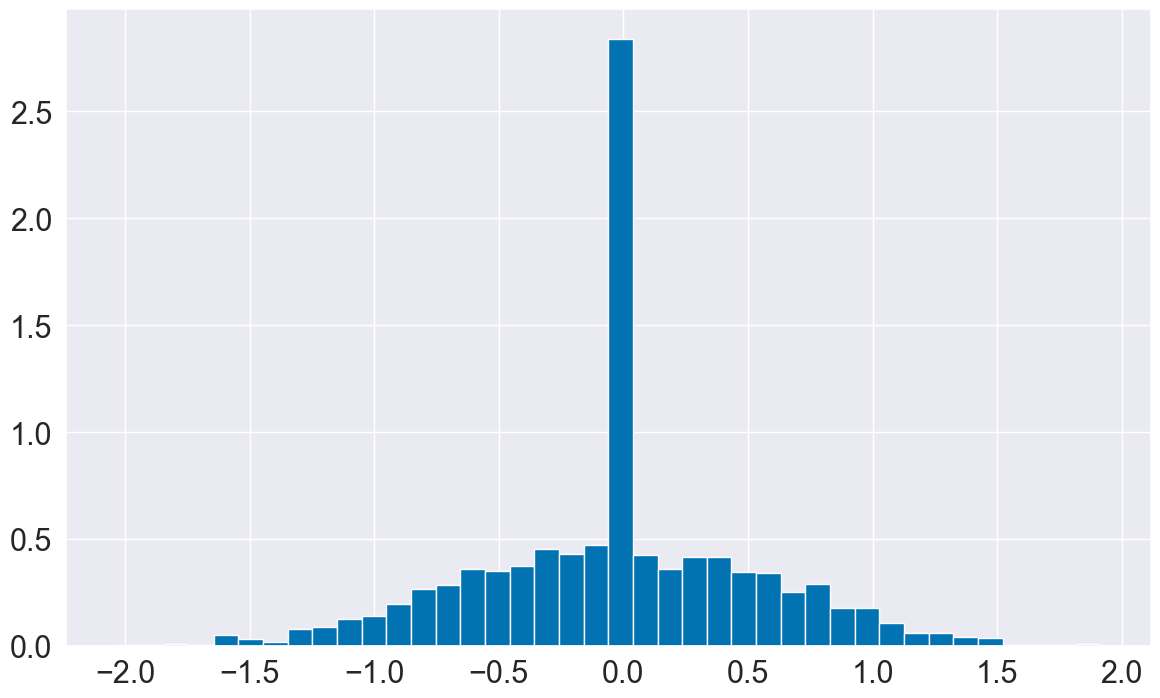

In [275]:
plt.hist(l1_smp_residuals[-1], bins=40, density=1)

### ii) Interior Point LP

In [276]:
l1_ipm_opt, l1_ipm_times, l1_ipm_residuals, l1_ipm_low = lp(Ab, 'l1', 'highs-ipm', 1)

In [277]:
print(l1_ipm_opt)
print(l1_ipm_low)
print(l1_ipm_times)

[ 13.96450782  56.34628742 176.28757375 367.82788344 807.641611  ]
[  -8.64075088  -40.47091323 -132.38945303 -265.56673929 -577.27186875]
[5.64830000e-03 3.11002000e-02 1.08617620e+00 6.07372150e+00
 3.94040816e+01]


## $l_\infty$ norm

### i) Simplex Method

In [278]:
linf_smp_opt, linf_smp_times, linf_smp_residuals, linf_smp_low = lp(Ab, 'linf', 'highs', 1)

In [279]:
print(linf_smp_opt)
print(linf_smp_low)
print(linf_smp_times)

[0.79580156 0.84143764 0.73656491 0.78238983 0.81606366]
[-0.53190349 -0.65544332 -0.5786504  -0.58076415 -0.6024764 ]
[2.26860000e-03 1.22230000e-02 8.69218700e-01 8.23178490e+00
 1.03728951e+02]


### ii) Interior Point LP

In [280]:
linf_ipm_opt, linf_ipm_times, linf_ipm_residuals, linf_ipm_low = lp(Ab, 'linf', 'highs-ipm', 1)

In [281]:
print(linf_ipm_opt)
print(linf_ipm_low)
print(linf_ipm_times)

[0.79580156 0.84143764 0.73656491 0.78238983 0.81606366]
[-0.53190349 -0.65544332 -0.5786504  -0.58076415 -0.6024764 ]
[5.69920000e-03 2.23744000e-02 5.48602100e-01 2.99498580e+00
 1.66693153e+01]


(array([3.41052207, 0.39490256, 0.46670302, 0.56243697, 0.45473628,
        0.4068693 , 0.52653674, 0.44276953, 0.49063651, 0.56243697,
        0.41883604, 0.45473628, 0.49063651, 0.55047023, 0.58637046,
        0.47866976, 0.53850348, 0.38293581, 0.46670302, 0.47866976,
        0.44276953, 0.55047023, 0.52653674, 0.51457   , 0.55047023,
        0.45473628, 0.49063651, 0.50260325, 0.61030395, 0.50260325,
        0.44276953, 0.39490256, 0.50260325, 0.49063651, 0.35900232,
        0.49063651, 0.2991686 , 0.44276953, 0.26326837, 3.11135347]),
 array([-8.16063661e-01, -7.75260478e-01, -7.34457295e-01, -6.93654112e-01,
        -6.52850929e-01, -6.12047746e-01, -5.71244563e-01, -5.30441380e-01,
        -4.89638197e-01, -4.48835014e-01, -4.08031831e-01, -3.67228647e-01,
        -3.26425464e-01, -2.85622281e-01, -2.44819098e-01, -2.04015915e-01,
        -1.63212732e-01, -1.22409549e-01, -8.16063661e-02, -4.08031831e-02,
         4.10782519e-14,  4.08031831e-02,  8.16063661e-02,  1.22409549e-01

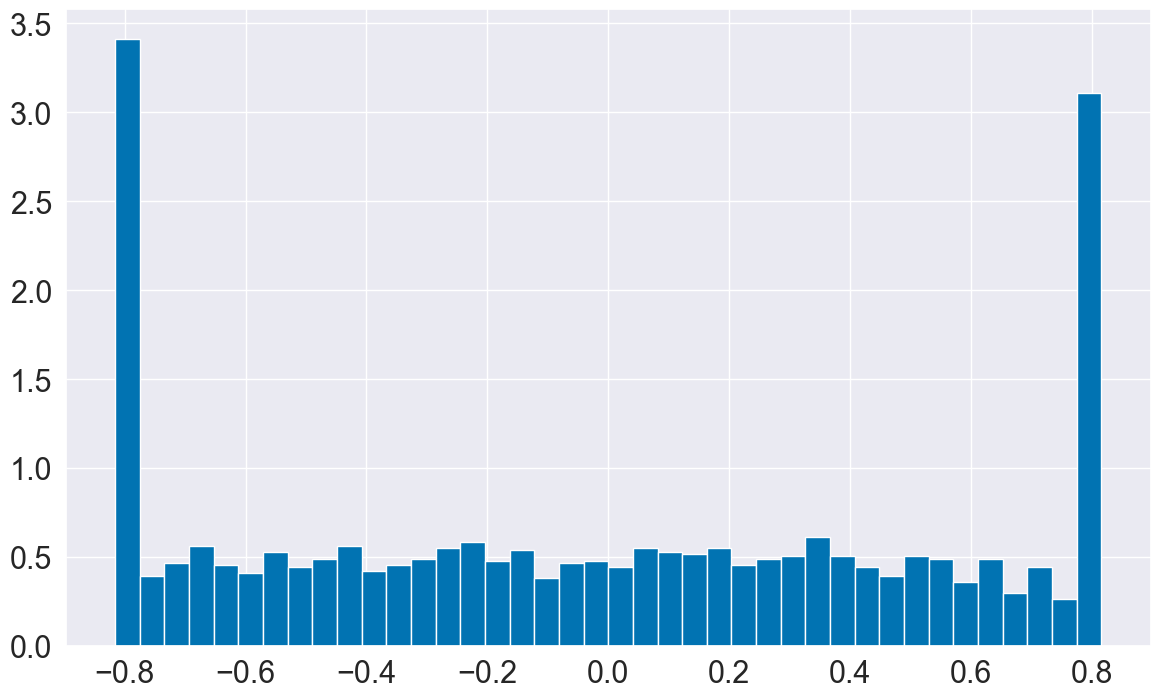

In [282]:
plt.hist(linf_ipm_residuals[-1], bins=40, density=1)

## $l_2$ norm

In [283]:
l2_lp_times = [0] * 5
l2_lp_opt = [None] * 5
l2_lp_residuals = [None] * 5
iterations = 10
for n in range(iterations):
    for i, (A,b) in enumerate(Ab):

        start_time = timeit.default_timer()
        x = inv(A.T @ A) @ A.T @ b
        time = timeit.default_timer() - start_time

        l2_lp_residuals[i] = A @ x - b

        l2_lp_opt[i] = np.sqrt(l2_lp_residuals[i].T @ l2_lp_residuals[i])
        l2_lp_times[i] += time / iterations

In [284]:
print(l2_lp_opt)
print(l2_lp_times)

[2.118139329453281, 5.189877332419184, 8.786675092974793, 12.460295288066254, 18.64969450788458]
[0.00016358000029867984, 0.022768199999336502, 0.1252445900001476, 0.2049274699998932, 0.32933183999994076]


(array([0.01571181, 0.        , 0.03142363, 0.03142363, 0.04713544,
        0.1099827 , 0.08641498, 0.11783861, 0.18854177, 0.36137173,
        0.36137173, 0.43993081, 0.45564262, 0.73845528, 0.70703165,
        0.69917575, 0.90342934, 0.7541671 , 0.91128524, 0.90342934,
        0.76202301, 0.9741325 , 0.73845528, 0.91914115, 0.79344663,
        0.73845528, 0.73059938, 0.47135444, 0.44778671, 0.38493946,
        0.51848988, 0.2121095 , 0.14140633, 0.12569452, 0.1099827 ,
        0.06284726, 0.02356772, 0.03142363, 0.02356772, 0.01571181]),
 array([-1.27378192, -1.21162726, -1.14947259, -1.08731793, -1.02516327,
        -0.96300861, -0.90085395, -0.83869929, -0.77654463, -0.71438997,
        -0.65223531, -0.59008065, -0.52792599, -0.46577133, -0.40361667,
        -0.34146201, -0.27930735, -0.21715269, -0.15499803, -0.09284337,
        -0.0306887 ,  0.03146596,  0.09362062,  0.15577528,  0.21792994,
         0.2800846 ,  0.34223926,  0.40439392,  0.46654858,  0.52870324,
         0.59085

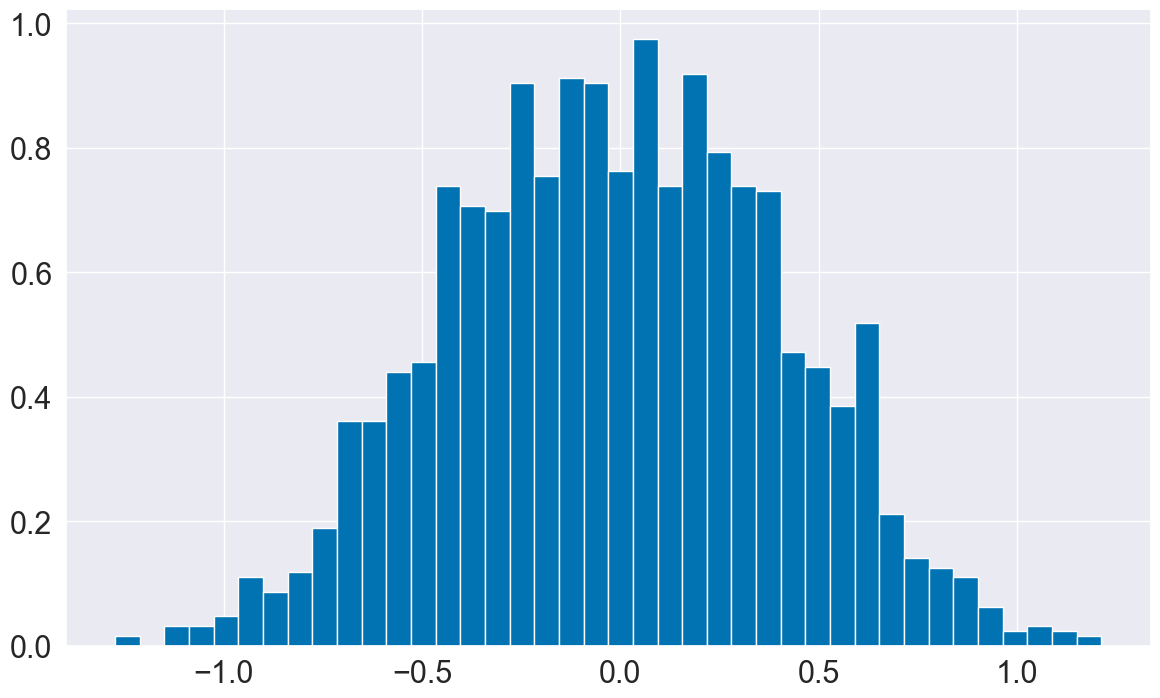

In [285]:
plt.hist(l2_lp_residuals[-1][:], bins=40, density=1)

# Test

In [295]:
c = np.array([[-2], [-3]])
A = np.array([[4, 8],
              [2, 1],
              [3, 2]])
b = np.array([[12], [3], [4]])

In [296]:
res = linprog(c, A_ub=A, b_ub=b, method='highs')
res_dual = linprog(-b, A_ub=A.T, b_ub=-c, bounds=(0, None),method='highs')

In [297]:
print(res['fun'], res_dual['fun'])

-4.75 -5.0
